In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import regex as re 
import nltk
from nltk import word_tokenize, pos_tag

In [48]:
# gensim 
# conda install -c conda-forge gensim
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaModel
from gensim.models.nmf import Nmf

In [3]:
# read pickled DF from notebook #1 (initial exploratory data visuals)
df = pd.read_pickle('df_un_general_debates.pkl')

# GENSIM
* Requires some slightly different formating compared with sklearn but fundamentally the same logic



###  For clarity, repeat some steps taken in notebook to prepare the text data #3
* re-initialise tf-idf vectorizer etc. 

In [5]:
%%time
## see notebook #3 for details on logic
# define the number of paragraphs of the text, splitting on the punctuation and ignoring the whitespace after them
df["paragraphs"] = df["text"].map(lambda text: re.split('[.?!]\s*\n', text))

Wall time: 1.21 s


In [116]:
# re-construct stopwords with additional corpus-specific elements (from notebook #2) to pass into tfidf_vectoriser 
stopwords = set(nltk.corpus.stopwords.words('english'))

In [117]:
# make manual adjustments 
additional_stopwords = {'dear','regards','also','would','must'}
exclude_stopwords = {'against'}

# user set operators to add or remove these elements from our base collection
stopwords |= additional_stopwords

## use the set difference to remove these words 
stopwords -= exclude_stopwords 

In [89]:
# reconstruct paragraph df 
paragraph_df = pd.DataFrame([{ "text": paragraph, "year": year } 
                               for paragraphs, year in zip(df["paragraphs"], df["year"]) 
                                    for paragraph in paragraphs if paragraph])

In [19]:
# E.G. 
paragraph_df.head(2)

,text,year
0,33: May I first convey to our President the co...,1970
1,34.\tIn taking up the work on the agenda of th...,1970


In [90]:
# gensim has no integrated tokenizer, expects each line is already tokenised 
## \b = word boundaries 
## \w = any alphanumeric char; equivalent to class: [a-zA-Z0-9]
gensim_paragraphs = [[w for w in re.findall(r'\b\w\w+\b' , paragraph.lower()) if w not in stopwords] 
                           for paragraph in paragraph_df["text"]]

In [18]:
# can see the required formatting is slightly different
## we also lose the year for time based trends analysis
gensim_paragraphs[0:2]

[['33',
  'may',
  'first',
  'convey',
  'president',
  'congratulations',
  'albanian',
  'delegation',
  'election',
  'presidency',
  'twenty',
  'fifth',
  'session',
  'general',
  'assembly'],
 ['34',
  'taking',
  'work',
  'agenda',
  'twenty',
  'fifth',
  'session',
  'general',
  'assembly',
  'held',
  'eve',
  'twenty',
  'fifth',
  'anniversary',
  'coming',
  'force',
  'charter',
  'united',
  'nations',
  'peace',
  'loving',
  'member',
  'states',
  'wished',
  'position',
  'present',
  'occasion',
  'picture',
  'positive',
  'satisfactory',
  'activity',
  'part',
  'united',
  'nations',
  'albanian',
  'delegation',
  'part',
  'taken',
  'great',
  'pleasure',
  'drawing',
  'balance',
  'sheet',
  'activities',
  'covering',
  'quarter',
  'century',
  'certainly',
  'short',
  'period',
  'life',
  'international',
  'organization',
  'unfortunately',
  'situation',
  'created',
  'day',
  'victory',
  'achieved',
  'powers',
  'rome',
  'berlintokyo',
  'ax

In [91]:
## uses: from gensim.corpora import Dictionary
## need to initialise a gensim dict of these tokenised documents (currently in list format)
## the dic = mapping from words to columns
dict_gensim_para = Dictionary(gensim_paragraphs)

In [25]:
# E.G. 
dict(list(dict_gensim_para.items())[:10])

{0: '33',
 1: 'albanian',
 2: 'assembly',
 3: 'congratulations',
 4: 'convey',
 5: 'delegation',
 6: 'election',
 7: 'fifth',
 8: 'first',
 9: 'general'}

* Can use gensim's `filter_extremes` siilar to scikit-learn's `TdidfVectorizer` to reduce the vocabulary size by filtering out words which appear too often or not enough
* Notation is like:
    * gensim's `no_below` = sklearn's `min_df`
    * Equivalently for no_above = max_df
    * Same integer and float rules apply 

In [92]:
# cut off absolute values below 5 (min words which appear in 5 documents)
# and cut off by not appearing in more than 70% of the documents 
dict_gensim_para.filter_extremes(no_below=5, no_above=0.7)

### Calculate gensim's "bag-of-words" matrix (labelled a corpus in Gensim)
* Uses Gensim's `doc2bow` short for document to bag-of-words, included in gensim dict package
* Then apply the tf-idf transformation using gensim.models `TfidfModel`

In [93]:
# bag-of-words initialisation 
bow_gensim_para = [dict_gensim_para.doc2bow(paragraph) for paragraph in gensim_paragraphs]

In [31]:
# E.G. BOW representation 
bow_gensim_para[:1]

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1)]]

In [94]:
## apply tfidf model from gensim 

# fit the BOW model 
tfidf_gensim_para = TfidfModel(bow_gensim_para)

# transform the weights to tfidf weights 
vectors_gensim_para = tfidf_gensim_para[bow_gensim_para]

## NON-NEGATIVE MATRIX FACTORISATION WITH GENSIM
* Base Model params:
    * `num_topics` = number of topics to extract
    * `kappa` = gradient descent step size; larger value makes model train faster but could lead to non-convergence if too large
    * `eval_every` = number of batches after which L2 norm of (v-Wh) is computed, where:
        * v = word-document matrix (input corpus)
        * W = word-topic matrix
        * h = topic-document matrix
        
        
* see docs for more information:
    * https://radimrehurek.com/gensim/models/nmf.html

In [95]:
nmf_gensim_para = Nmf(vectors_gensim_para, num_topics=10,
                      id2word=dict_gensim_para, kappa=0.1, eval_every=5)

In [53]:
## there is an inbuilt print topics function but it's a little ugly by default 
# nmf_gensim_para.print_topics()

In [54]:
# define function for displaying gensim topics 
def display_topics_gensim(model):
    for topic in range(0, model.num_topics):
        print("\nTopic %02d" % topic)
        for (word, prob) in model.show_topic(topic, topn=6):
            print("  %s (%2.3f)" % (word, prob))

In [55]:
# display topics 
display_topics_gensim(nmf_gensim_para)


Topic 00
  east (0.018)
  middle (0.016)
  israel (0.015)
  peace (0.014)
  security (0.014)
  arab (0.013)

Topic 01
  nations (0.014)
  united (0.013)
  world (0.010)
  organization (0.009)
  peace (0.008)
  security (0.006)

Topic 02
  human (0.015)
  rights (0.013)
  international (0.010)
  law (0.008)
  conference (0.006)
  sea (0.006)

Topic 03
  general (0.024)
  assembly (0.020)
  secretary (0.011)
  delegation (0.010)
  session (0.009)
  president (0.008)

Topic 04
  republic (0.041)
  people (0.025)
  china (0.016)
  democratic (0.015)
  korea (0.015)
  united (0.014)

Topic 05
  countries (0.018)
  development (0.015)
  nuclear (0.015)
  economic (0.014)
  developing (0.014)
  weapons (0.010)

Topic 06
  peoples (0.021)
  people (0.015)
  struggle (0.014)
  against (0.011)
  independence (0.010)
  freedom (0.009)

Topic 07
  international (0.008)
  states (0.007)
  non (0.006)
  relations (0.006)
  co (0.005)
  countries (0.005)

Topic 08
  africa (0.024)
  african (0.016)


## GENSIM (Latent Dirichlet Allocation) LDA 
* `id2word` = mapping from word IDs to words
* `chunksize` = number of documents to be used in each training chunk 
* `passes` = number of passes through the corpus during training
* `alpha` = A-prior belief of document-topic distribution (we will leave as auto)
* `eta` = A-prior belief of topic-word distribution (we will leave as auto)
* `iterations` = max number of iterations when trying to infer the topic distribution 
* We will set a random_state so the code is reproducable 

* Documentation here: 
    * https://radimrehurek.com/gensim/models/ldamodel.html

In [49]:
%%time

lda_gensim_para = LdaModel(corpus=bow_gensim_para, id2word=dict_gensim_para, chunksize=2000,
    alpha='auto', eta='auto', iterations=400, num_topics=10, passes=20, eval_every=None, random_state=42)

Wall time: 15min 53s


In [51]:
# lda_gensim_para.print_topics()

In [56]:
# display topics 
display_topics_gensim(lda_gensim_para)


Topic 00
  years (0.032)
  year (0.030)
  government (0.021)
  conference (0.016)
  since (0.012)
  ago (0.012)

Topic 01
  africa (0.073)
  african (0.068)
  continent (0.024)
  libya (0.019)
  crimes (0.017)
  crime (0.017)

Topic 02
  development (0.059)
  countries (0.035)
  economic (0.023)
  global (0.019)
  climate (0.019)
  sustainable (0.018)

Topic 03
  world (0.029)
  human (0.018)
  us (0.017)
  rights (0.015)
  one (0.013)
  today (0.010)

Topic 04
  republic (0.036)
  regional (0.033)
  cooperation (0.031)
  region (0.028)
  union (0.028)
  dialogue (0.027)

Topic 05
  people (0.094)
  country (0.033)
  against (0.028)
  syria (0.017)
  government (0.017)
  children (0.014)

Topic 06
  peace (0.040)
  conflict (0.035)
  east (0.022)
  state (0.021)
  solution (0.020)
  middle (0.019)

Topic 07
  nuclear (0.062)
  weapons (0.060)
  convention (0.031)
  arms (0.026)
  non (0.026)
  treaty (0.023)

Topic 08
  nations (0.040)
  united (0.039)
  international (0.031)
  securi

* A bit of a shame that we have some "stopword" like words still
    * such as: 'like', 'since' , 'ago', 'last'
    * Would have hoped these would appear in > 70% of the docs and be filtered out
* Definitely could be some benefit to lemmatisation to take out similar meanings, such as: 
        * Africa / African
    
    
* Topics in general seem a little more muddled than NMF + too many top-level, general terms which don't have much meaning
    * Could also update our custom stopwords list

## Reduce feature space to just (Nouns & Adjectives) - resample Gensim NMF model 
* Noun == 'NN'
* Adjective == 'JJ' 
* Can utilise nltk's `pos_tag` to check the tags 
* Also uses NLTK's `word_tokenize` function



* This could hopefully also act as a quick fix for filtering out some oddities in the vocabulary etc.
* Will also help cut down on training time 

In [61]:
## function to pull out nouns/adjectives from a string of text
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [60]:
paragraph_df

,text,year
0,33: May I first convey to our President the co...,1970
1,34.\tIn taking up the work on the agenda of th...,1970
2,35.\tThe utilization of the United Nations to ...,1970
3,36.\tThe whole of progressive mankind recalls ...,1970
4,37.\tAll this has had well known consequences ...,1970
...,...,...
282205,"For some months now, we have watched heartbrea...",2015
282206,This tragic situation could have been avoided ...,2015
282207,"My country, Zimbabwe, is committed to a fair, ...",2015
282208,We invite other countries with which we may ha...,2015


In [59]:
#E.G. original text 
paragraph_df.iloc[0]['text']

'33: May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth session of the General Assembly'

In [62]:
# warning: takes some time (inefficient due to .join)
## perhaps worthwhile to find a more optimised way to do this 
paragraph_df_nouns_adj = pd.DataFrame(paragraph_df.text.apply(nouns_adj))

In [63]:
# E.G. just nouns & adjectives 
paragraph_df_nouns_adj.iloc[0]['text']

'May President congratulations Albanian delegation election Presidency twenty-fifth session General Assembly'

In [64]:
# pickle DF for subsequent use if needed 
paragraph_df_nouns_adj.to_pickle('paragraph_df_nouns_adj.pkl')

In [66]:
#E.G. 
paragraph_df_nouns_adj.head(3)

,text
0,May President congratulations Albanian delegat...
1,work agenda twenty- fifth session General Asse...
2,utilization United Nations policy Organization...


In [118]:
# also make some further adjustments to our stopwords based off LDA results etc.
additional_stopwords = {'like ','since','ago','us','year', 'secretary', 'session', 'one', 'today', 'conference',
                       'assembly', 'congratulations', 'President', 'mr', 'nations', 'united', 'general', 'mrs'}

# user set operators to add or remove these elements from our base collection
stopwords |= additional_stopwords

In [119]:
%%time

# formulate new gensim paragraphs variable 
gensim_paragraphs_nounds_adj = [[w for w in re.findall(r'\b\w\w+\b' , paragraph.lower()) if w not in stopwords] 
                           for paragraph in paragraph_df_nouns_adj["text"]]

Wall time: 7.37 s


* For brevity, the same steps are repeated as in the first NMF set-up, refer to that code for comments

In [120]:
dict_gensim_para = Dictionary(gensim_paragraphs_nounds_adj)

In [121]:
dict_gensim_para.filter_extremes(no_below=6, no_above=0.7)

In [122]:
bow_gensim_para = [dict_gensim_para.doc2bow(paragraph) for paragraph in gensim_paragraphs_nounds_adj]

In [123]:
## apply tfidf model from gensim on nouns-adj only DF paragraph data ## 

# fit the BOW model 
tfidf_gensim_para = TfidfModel(bow_gensim_para)

# transform the weights to tfidf weights 
vectors_gensim_para = tfidf_gensim_para[bow_gensim_para]

In [124]:
%%time

# run nmf model again on new nouns-adj only DF, same number of topics and step-val (kappa)
nmf_gensim_para = Nmf(vectors_gensim_para, num_topics=10,
                      id2word=dict_gensim_para, kappa=0.1, eval_every=5)

Wall time: 49.9 s


In [125]:
# display topics again & compare
display_topics_gensim(nmf_gensim_para)


Topic 00
  africa (0.041)
  south (0.036)
  namibia (0.021)
  african (0.019)
  struggle (0.016)
  apartheid (0.016)

Topic 01
  republic (0.041)
  people (0.028)
  china (0.021)
  charter (0.020)
  principles (0.019)
  government (0.016)

Topic 02
  peace (0.024)
  international (0.017)
  security (0.015)
  organization (0.011)
  community (0.008)
  role (0.008)

Topic 03
  states (0.021)
  soviet (0.011)
  resolution (0.011)
  europe (0.011)
  agreement (0.011)
  relations (0.011)

Topic 04
  nuclear (0.028)
  disarmament (0.021)
  development (0.020)
  weapons (0.018)
  arms (0.013)
  countries (0.010)

Topic 05
  human (0.023)
  rights (0.020)
  problems (0.020)
  new (0.014)
  organization (0.009)
  great (0.008)

Topic 06
  economic (0.036)
  co (0.033)
  operation (0.031)
  international (0.019)
  order (0.016)
  social (0.012)

Topic 07
  countries (0.024)
  world (0.017)
  situation (0.008)
  peoples (0.008)
  non (0.007)
  crisis (0.006)

Topic 08
  east (0.031)
  middle (0.

* Not bad, seems to have given a clearer picture about some topics
    * E.G. topic 4 is nuclear disarmment & weapons
    * Topic 8 covers middle-east and the israel/palestine conflict 
    * Topic 5 is human rights & problems etc.
    * Topic 3 is interesting, about EU and relations + possibly with ex-soviet nations
    * Topic 1 has some elements about China
    * problems in SA and the middle-east re-appear

    
* Still run into some problems without lemmaisation with double entiries in words like "rights" and "right" 
* Also some compound words like "co-operation" have been split into 2 tokens 

# Remaining issue: are we choosing the right amount of topics? 


## Coherence Scores
* Gensim has a `CoherenceModel` class that can handle the 4 steps for calculating topic coherence
    * Segmentation
    * Probability estimation
    * confirmation measure calculation
    * Aggregation 


In [82]:
# make a new import from gensim 
from gensim.models.coherencemodel import CoherenceModel

* note: nouns/adj and base model share same variable names so need to run in order to get separate results
    * Else, add a suffix to one or both of the models to differeniate if that suitsyour needs 

In [96]:
# compare 1st & 2nd NMF models
## base NMF
nmf_gensim_para_coherence = CoherenceModel(model=nmf_gensim_para,
    texts=gensim_paragraphs, dictionary=dict_gensim_para, coherence='c_v')

nmf_gensim_para_coherence_score = nmf_gensim_para_coherence.get_coherence()

print("Base NMF Model Sxore: {}.".format(nmf_gensim_para_coherence_score))

Base NMF Model Sxore: 0.6151409009359116.


In [100]:
## LDA 
lda_gensim_para_coherence = CoherenceModel(model=lda_gensim_para,
    texts=gensim_paragraphs, dictionary=dict_gensim_para, coherence='c_v')
lda_gensim_para_coherence_score = lda_gensim_para_coherence.get_coherence()

print("LDA Model Sxore: {}.".format(lda_gensim_para_coherence_score))

LDA Model Sxore: 0.576532582810055.


In [127]:
## -------------------------------------------------## 
## nouns and adjectives only NMF
nmf_gensim_para_coherence = CoherenceModel(model=nmf_gensim_para,
    texts=gensim_paragraphs, dictionary=dict_gensim_para, coherence='c_v')

nmf_gensim_para_coherence_score = nmf_gensim_para_coherence.get_coherence()

print("Nouns-Adjectives NMF Model Sxore: {}.".format(nmf_gensim_para_coherence_score))

Nouns-Adjectives NMF Model Sxore: 0.6072921717892769.


* The higher the score, the better the approximation to the real topics 
* The nouns-adjectives model & the base NMF model perform roughly the same
* The LDA model didn't perform well, and took substantially longer to train (15m vs 1-2m) 
    * Although, more work could be done to tune the model 
    * This might be part of future work

* Can also get the coherence score of individual topics 

In [128]:
# for nouns-adjectives NMF
top_topics = nmf_gensim_para.top_topics(vectors_gensim_para, topn=6)

In [131]:
#E.g.
top_topics[:1]

[([(0.031236769487900887, 'east'),
   (0.027984945582062062, 'middle'),
   (0.023893053877144438, 'israel'),
   (0.02251456746956367, 'arab'),
   (0.0223693948242925, 'palestinian'),
   (0.019910868623098727, 'people')],
  -1.155490612081729)]

In [139]:
avg_topic_coherence = sum([t[1] for t in top_topics]) / len(top_topics)

print("Average Topic Coherence: {}".format(avg_topic_coherence))

Average Topic Coherence: -1.9957769661031066


In [140]:
# can inspect for each topic individually
## higher scores are better (E.G. east, middle, israel palestinian) is the most "coherent"
[(t[1], " ".join([w[1] for w in t[0]])) for t in top_topics] #sub-slice the top_topics list 

[(-1.155490612081729, 'east middle israel arab palestinian people'),
 (-1.6363945447465116,
  'nuclear disarmament development weapons arms countries'),
 (-1.7113783915357736, 'economic co operation international order social'),
 (-1.8158564389964154, 'africa south namibia african struggle apartheid'),
 (-1.9113228964241165,
  'peace international security organization community role'),
 (-2.025151221821317, 'president delegation election behalf great success'),
 (-2.20819448068473, 'human rights problems new organization great'),
 (-2.2588490321510837, 'republic people china charter principles government'),
 (-2.58342252164619, 'countries world situation peoples non crisis'),
 (-2.6517095209431996, 'states soviet resolution europe agreement relations')]

## Optimise Number of (Nouns/Adjectives) NMF Topics 
* Loop through different `num_topics` quantities and view coherence scores by number
* each iteration takes around 1-1.5m

In [153]:
from tqdm.auto import tqdm

In [154]:
# initialise list 
nmf_para_models_n = []

# aka check (6,8,10,12,14, 16)
for n in tqdm(range(6, 18, 2)):
    
    # initialise NMF model 
    nmf_gensim_para = Nmf(vectors_gensim_para, num_topics=n,
                      id2word=dict_gensim_para, kappa=0.1, eval_every=5)
    
    # initialise coherence model 
    nmf_gensim_para_coherence = CoherenceModel(model=nmf_gensim_para,
    texts=gensim_paragraphs, dictionary=dict_gensim_para, coherence='c_v')
    
    # append to list
    nmf_para_models_n.append(nmf_gensim_para_coherence.get_coherence())


  0%|          | 0/6 [00:00<?, ?it/s]

In [156]:
# define labels
topics = [6, 8, 10, 12, 14, 16]

# zip lists
zipped_coherence_topics = list(zip(topics, nmf_para_models_n))

# convert to df 
coherence_scores_df = pd.DataFrame(zipped_coherence_topics, columns=['number_topics', 'coherence'])

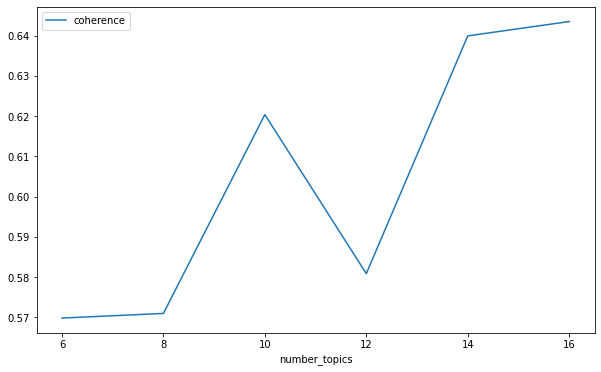

In [161]:
# plot coherence by # topics 
coherence_scores_df.set_index('number_topics')[['coherence']].plot(figsize=(10,6));

* There is pretty strong rationale to support increasing the number of topics
* Although, all things considered, 10 performs quite well by chance compared to 6-12 values

## Hierarchical Dirichlet Process
* A process to define a few broad topics + go into more detail about subtopics below them
    * Could for handling the varying topic sizes and topic overlap
* Generally, could be a "starting point" to see if a topic is really big and might warrant its own subset


* **NOTE: This is an experimental implementation from Gensim + HDP is fairly new**
    * The below illustration is more for curiosity at this point 

In [162]:
from gensim.models import HdpModel

In [163]:
# use the bag-of-words vectorisation instance generated at the beginning of the notebook 
hdp_gensim_para = HdpModel(corpus=bow_gensim_para, id2word=dict_gensim_para)

In [171]:
# in-built print function - fairly ugly & hard to read
# hdp_gensim_para.print_topics(num_words=10)

In [165]:
words = 8
pd.DataFrame([re.split(r" \+ |\*", t[1]) for t in hdp_gensim_para.print_topics(num_topics=20, num_words=words)])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.021,countries,0.018,international,0.017,world,0.015,development,0.015,economic,0.007,new,0.006,states,0.006,peace
1,0.014,peace,0.013,international,0.011,states,0.010,security,0.010,nuclear,0.009,world,0.009,people,0.008,countries
2,0.013,international,0.012,world,0.011,peace,0.010,people,0.008,countries,0.007,states,0.007,country,0.007,human
3,0.015,africa,0.015,people,0.013,south,0.011,international,0.008,world,0.008,countries,0.008,african,0.007,peace
4,0.017,international,0.010,world,0.010,countries,0.009,peace,0.009,states,0.008,security,0.006,economic,0.006,development
5,0.014,international,0.012,countries,0.011,world,0.009,peace,0.008,economic,0.007,states,0.007,people,0.007,development
6,0.014,international,0.010,world,0.010,countries,0.009,peace,0.008,people,0.007,security,0.007,states,0.006,economic
7,0.014,international,0.013,countries,0.011,world,0.008,economic,0.008,development,0.008,peace,0.007,states,0.006,people
8,0.014,international,0.010,world,0.010,countries,0.009,peace,0.007,states,0.007,economic,0.007,development,0.007,people
9,0.013,international,0.010,world,0.010,countries,0.009,peace,0.007,people,0.007,development,0.007,states,0.007,economic


* Interesting idea that could be explored further in future work
    * Would need to custom filter out a few extremeley prevalent corpus-speficic words like "international" etc. 

In [172]:
# zoom in on 1 topic 
hdp_gensim_para.show_topic(1, topn=15)

[('peace', 0.014378876403604376),
 ('international', 0.012610282669647152),
 ('states', 0.011441286975724508),
 ('security', 0.010136356208008925),
 ('nuclear', 0.009795250514887933),
 ('world', 0.009311782584736012),
 ('people', 0.009229979987078434),
 ('countries', 0.007862220485948219),
 ('east', 0.006370771407652383),
 ('weapons', 0.0063643871741134875),
 ('israel', 0.005097472483782026),
 ('government', 0.005029713177325867),
 ('middle', 0.004821536920777888),
 ('council', 0.004685103992582685),
 ('war', 0.004481879419780385)]